# Limiations of TMAD

Potential impact of BRDF (and other data problem) in TMAD

In [13]:
from matplotlib import pyplot as plt

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_dask import create_local_dask_cluster

In [ ]:
#create_local_dask_cluster(n_workers=14,threads_per_worker=1)

In [2]:
import datacube
dc = datacube.Datacube()

## Find problematic area

In [3]:
lat, lon = (20, 20.5), (28, 28.5)

lat, lon = (20.4, 20.45), (28.11, 28.16)

#lat, lon = (20.3, 20.5), (28.05, 28.55)

crs = mostcommon_crs(dc, 's2_l2a', {'lat':lat, 'lon':lon, 'time':'2019'})

res = (-20, 20)

In [8]:
s2_stats = dc.load(product ='ga_s2_gm', lat=lat, lon=lon, output_crs = crs, resolution=res, measurements=['COUNT', 'EMAD', 'SMAD', 'BCMAD']).squeeze()
s2_stats

<xarray.Dataset>
Dimensions:      (x: 263, y: 280)
Coordinates:
    time         datetime64[ns] 2019-07-02T11:59:59.999999
  * y            (y) float64 2.262e+06 2.262e+06 ... 2.256e+06 2.256e+06
  * x            (x) float64 6.158e+05 6.158e+05 6.158e+05 ... 6.21e+05 6.21e+05
    spatial_ref  int32 32635
Data variables:
    COUNT        (y, x) uint16 61 61 61 61 61 61 61 ... 117 117 117 117 116 117
    EMAD         (y, x) float32 330.63016 321.1668 ... 386.60562 394.49265
    SMAD         (y, x) float32 9.446388e-05 0.00010082206 ... 9.526239e-05
    BCMAD        (y, x) float32 0.0073075704 0.0071438844 ... 0.009819983
Attributes:
    crs:           epsg:32635
    grid_mapping:  spatial_ref

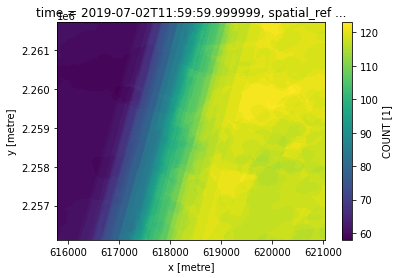

In [5]:
s2_stats.COUNT.plot.imshow();

90.93829715820094 118.24290845329337 61.22161234991424


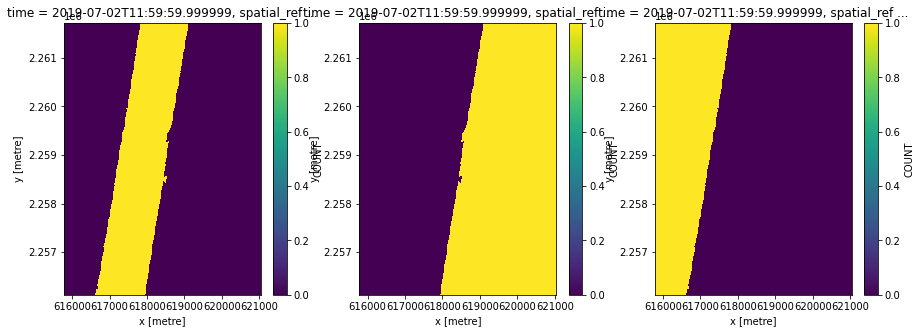

In [57]:
cut1, cut2 = 70, 110
edge = (s2_stats.COUNT>=cut1) & (s2_stats.COUNT<=cut2)
overlap = s2_stats.COUNT>cut2
other = s2_stats.COUNT<cut1

fig, axes = plt.subplots(1,3, figsize=(15,5))
edge.plot.imshow(ax=axes[0]);
overlap.plot.imshow(ax=axes[1]);
other.plot.imshow(ax=axes[2]);

print(s2_stats.COUNT.where(edge).mean().values,s2_stats.COUNT.where(overlap).mean().values,s2_stats.COUNT.where(other).mean().values)

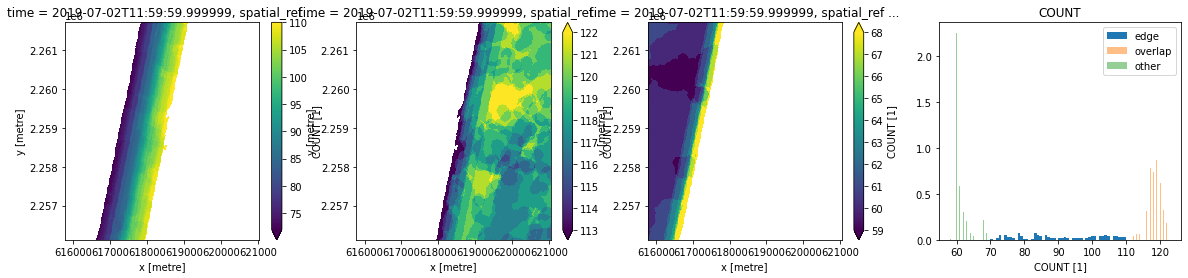

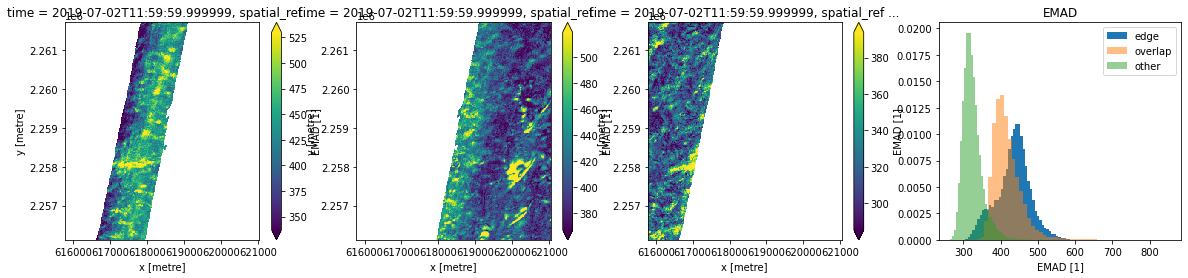

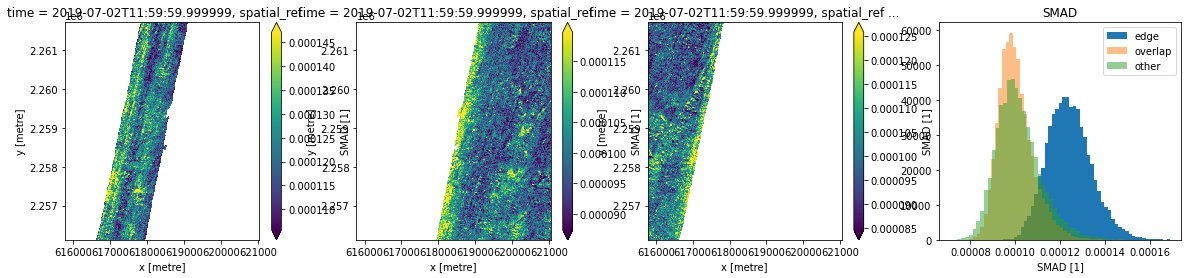

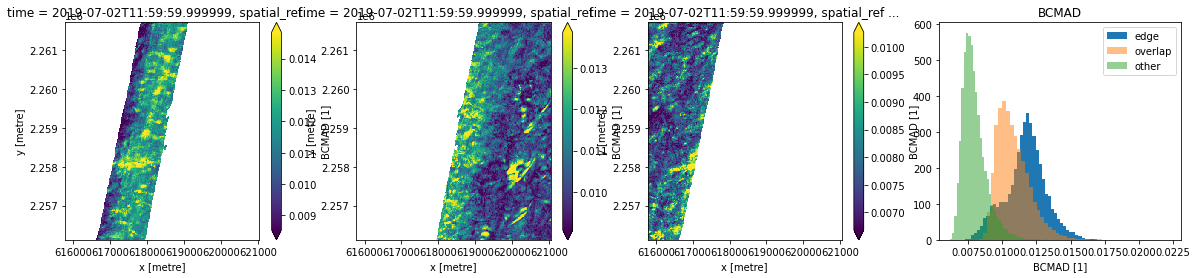

In [72]:
def plot_sections(ds, band):
    fig, axes = plt.subplots(1,4, figsize=(20,4))
    ds[band].where(edge).plot.imshow(robust=True, ax=axes[0]);
    ds[band].where(overlap).plot.imshow(robust=True, ax=axes[1]);
    ds[band].where(other).plot.imshow(robust=True, ax=axes[2]);

    ds[band].where(edge).plot.hist(bins=50, ax = axes[3], density=True, label='edge');
    ds[band].where(overlap).plot.hist(bins=50, ax = axes[3], density=True, label='overlap', alpha=0.5);
    ds[band].where(other).plot.hist(bins=50, ax = axes[3], density=True, label='other', alpha=0.5);
    axes[3].legend();
    axes[3].set_title(band)
    
plot_sections(s2_stats, 'COUNT')
plot_sections(s2_stats,'EMAD')
plot_sections(s2_stats,'SMAD')
plot_sections(s2_stats,'BCMAD')

## Underlying deviation distributions

In [63]:
import hdstats
import numpy as np

In [64]:
measurements = ['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12']

In [65]:
data = load_ard(dc, products=['s2_l2a'], lat=lat, lon=lon, time='2019', #dask_chunks={'x':500, 'y':500},
                output_crs = crs, resolution=res, measurements=measurements)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 139 time steps


In [67]:
arr = data.to_array(dim='band').transpose('y','x','band','time').values
gm = hdstats.nangeomedian_pcm(arr, nocheck=False, eps=1e-6)
edist = hdstats.eucdist(arr, gm)
emad = np.nanmedian(edist, axis=2)
cdist = hdstats.cosdist(arr, gm)
smad = np.nanmedian(cdist, axis=2)

Automatically using 64 threads.
Automatically using 64 threads.
Automatically using 64 threads.


In [91]:
data['edist']= ('y','x','time'), np.log(edist)
data['cdist']= ('y','x','time'), np.log(cdist)

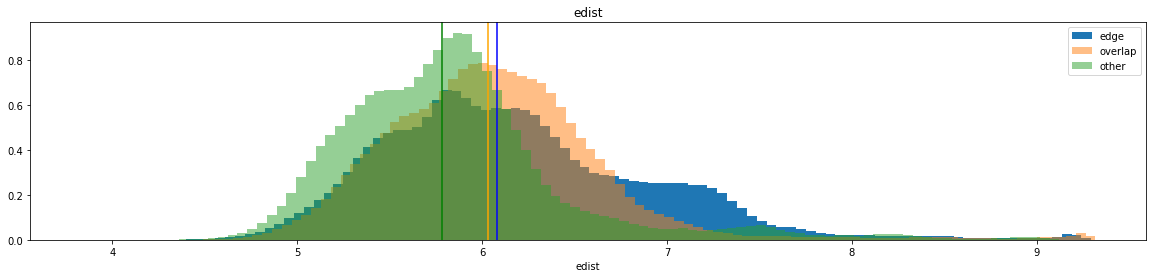

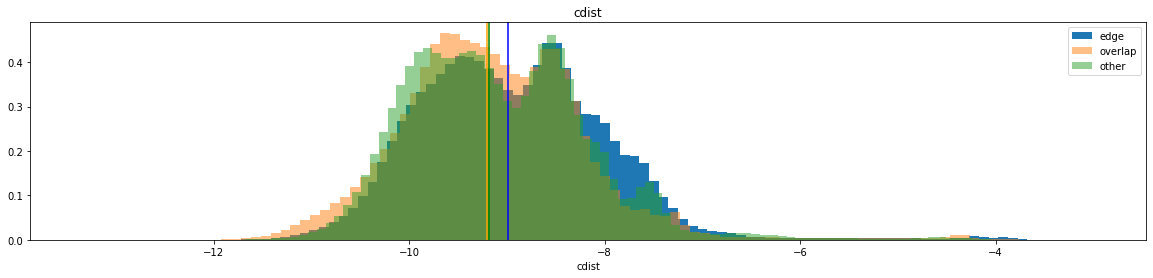

In [117]:
def plot_sections_hist(ds, band):
    fig, axes = plt.subplots(1,1, figsize=(20,4))
    ds[band].where(edge).plot.hist(bins=100, ax = axes, density=True, label='edge');
    axes.axvline(ds[band].where(edge).median().values, color='blue')
    ds[band].where(overlap).plot.hist(bins=100, ax = axes, density=True, label='overlap', alpha=0.5);
    axes.axvline(ds[band].where(overlap).median().values, color='orange')
    ds[band].where(other).plot.hist(bins=100, ax = axes, density=True, label='other', alpha=0.5);
    axes.axvline(ds[band].where(other).median().values, color='green')
    axes.legend();
    axes.set_title(band)
    
plot_sections_hist(data, 'edist')
plot_sections_hist(data, 'cdist')

In [ ]:
#s2_stats['emad_fly'] = ('y', 'x'), emad
#s2_stats['smad_fly'] = ('y', 'x'), smad

In [ ]:
#s2_stats.emad_fly.plot.imshow(robust=True);

In [ ]:
#s2_stats.smad_fly.plot.imshow(robust=True);

## With BRDF corrections

In [66]:
from s2_brdf import *

In [93]:
%%time

dss = dc.find_datasets(product='s2_l2a', time='2019', lat=lat, lon=lon)
band_names = measurements

# get BRDF factor for each scene, per band

brdfs = {}
for band_name in band_names:
    brdfs[band_name] = []
    
for ds in dss:
    xml = get_xml(ds)
    parsed = parse_xml(xml)
    for band_name in band_names:
        brdf_flood = normalized_brdf(parsed, band_name, method = 'flood')
        brdf_flood = brdf_flood.expand_dims({'time':[ds.time.begin]})
        brdfs[band_name].append(brdf_flood)

# merge according to band and time

brdf = None
for band_name in band_names:
    d = xr.concat(brdfs[band_name], dim='time')
    d = d.sortby('time')
    d = d.expand_dims({'band':[band_name]})
    if brdf is None: brdf = d
    else: brdf = xr.concat([brdf, d], dim='band')

brdf = brdf.to_dataset(dim='band')
brdf.coords['time'] = brdf.time.astype('<M8[ns]')

CPU times: user 2min 4s, sys: 673 ms, total: 2min 5s
Wall time: 2min 20s


In [94]:
brdf = brdf.astype(np.float32)

In [95]:
%%time

def fill_nan(row, method='nearest'):
    # extraplate a partial row
    valid = ~np.isnan(row)
    if valid.all(): return row
    if valid.sum()<2: return row
    output_x = np.arange(len(row))
    input_x = output_x[valid]
    f = interpolate.interp1d(input_x, row[valid], kind=method, fill_value='extrapolate')
    return f(output_x)

def fill_2d(input_table):
    table = input_table.copy()
    for irow, row in enumerate(table):
        table[irow] = fill_nan(row)
    return table
        

filled_brdf = brdf.copy()

for b in list(brdf.data_vars):
    filled_brdf[b] = brdf[b].groupby('time').apply(lambda x: fill_2d(x.values))

CPU times: user 3.63 s, sys: 584 µs, total: 3.63 s
Wall time: 3.63 s


In [96]:
#brdf.B03.isel(time=slice(0,20)).plot.imshow(col='time', col_wrap=10, vmin=0.95, vmax=1.05);

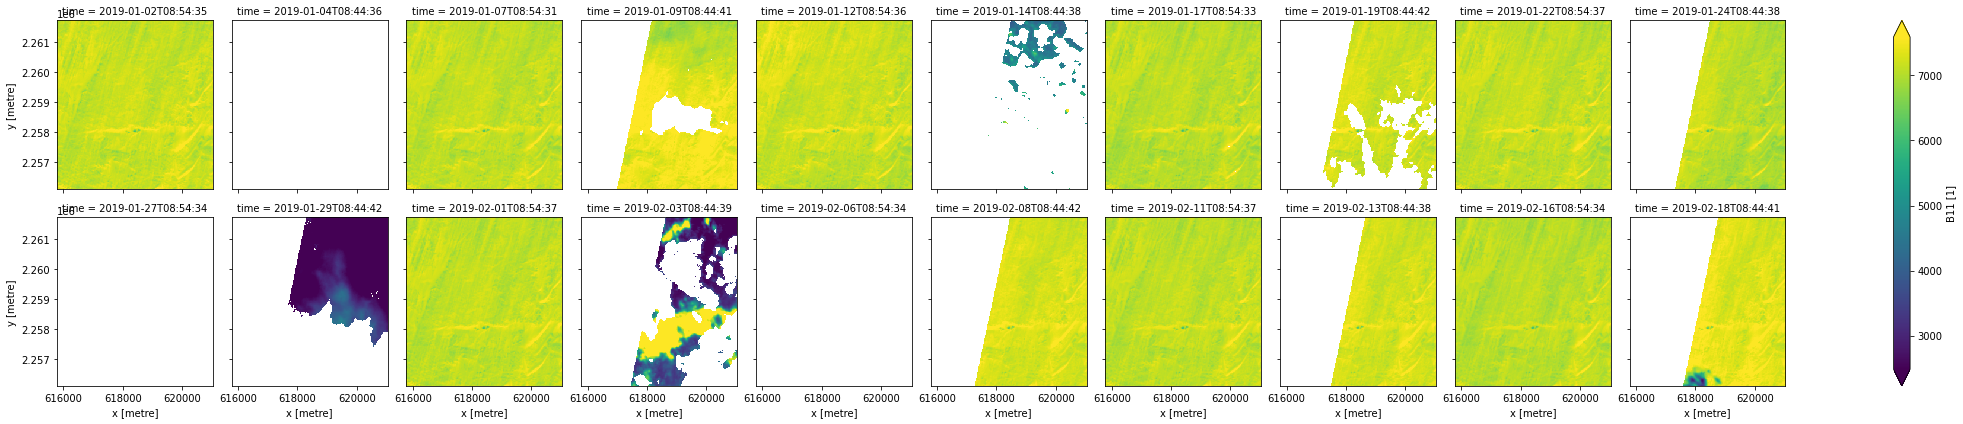

In [146]:
data.B11.isel(time=slice(0,20)).plot.imshow(col='time', col_wrap=10, robust=True);

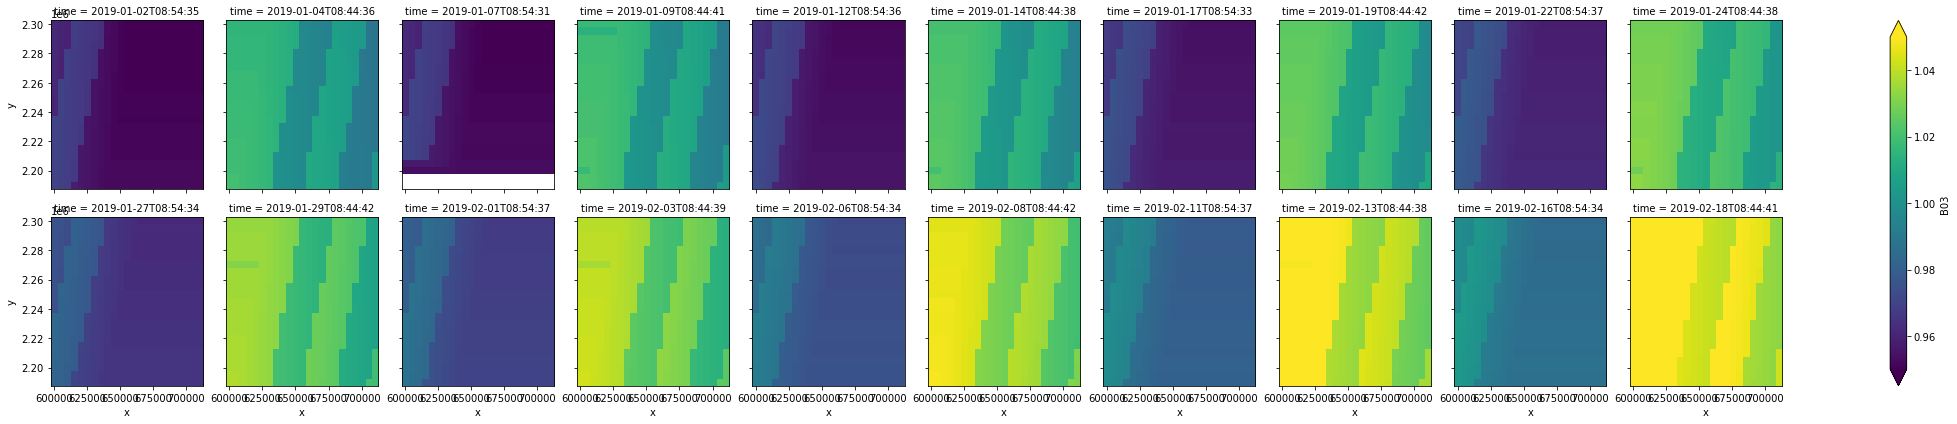

In [97]:
#filled_brdf.B03.isel(time=slice(0,20)).plot.imshow(col='time', col_wrap=10, vmin=0.95, vmax=1.05);

In [104]:
%%time

corrected_data = data[measurements]/filled_brdf.interp(x=data.x.values, y = data.y.values, method='linear').astype(np.float32)

CPU times: user 1.02 s, sys: 859 ms, total: 1.88 s
Wall time: 1.88 s


In [ ]:
#%%time

#from s2_geomedian import xr_geomedian_tmad
#ref = xr_geomedian_tmad(data/factor).compute()

In [106]:
arr = corrected_data.to_array(dim='band').transpose('y','x','band','time').values
gm = hdstats.nangeomedian_pcm(arr, nocheck=False, eps=1e-6)
corrected_edist = hdstats.eucdist(arr, gm)
corrected_emad = np.nanmedian(corrected_edist, axis=2)
corrected_cdist = hdstats.cosdist(arr, gm)
corrected_smad = np.nanmedian(corrected_cdist, axis=2)

Automatically using 64 threads.
Automatically using 64 threads.
Automatically using 64 threads.


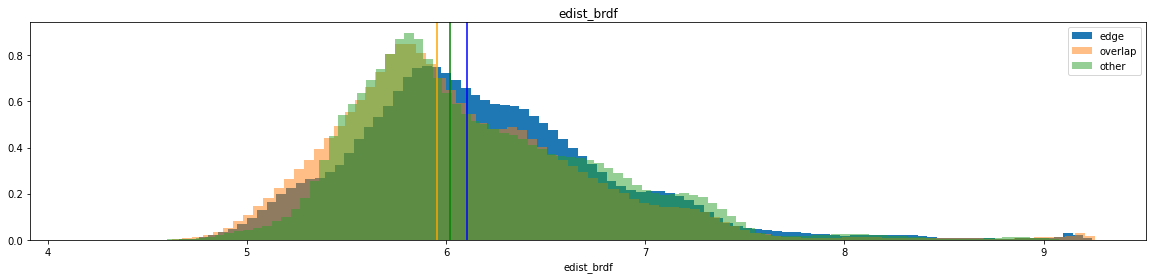

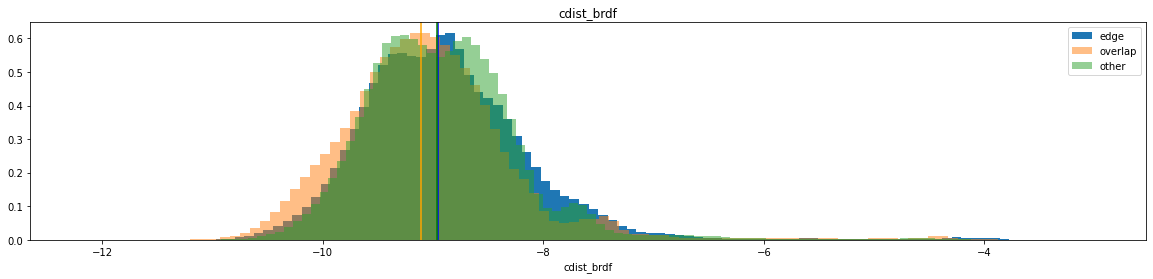

In [118]:
data['edist_brdf']= ('y','x','time'), np.log(corrected_edist)
data['cdist_brdf']= ('y','x','time'), np.log(corrected_cdist)

plot_sections_hist(data, 'edist_brdf')
plot_sections_hist(data, 'cdist_brdf')

In [130]:
s2_stats['emad_brdf'] = ('y', 'x'), corrected_emad
s2_stats['smad_brdf'] = ('y', 'x'), corrected_smad

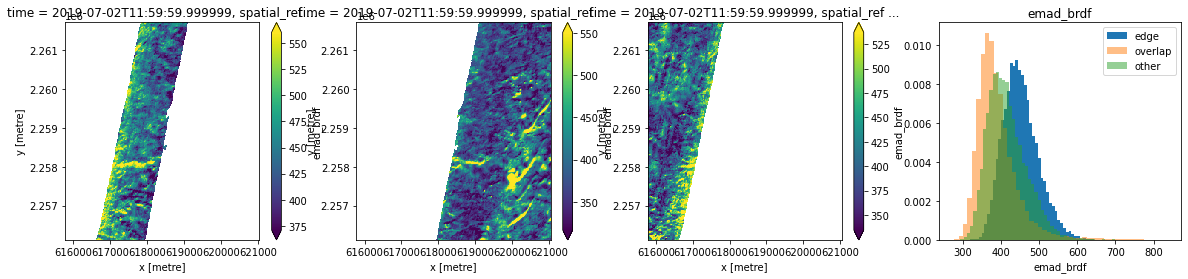

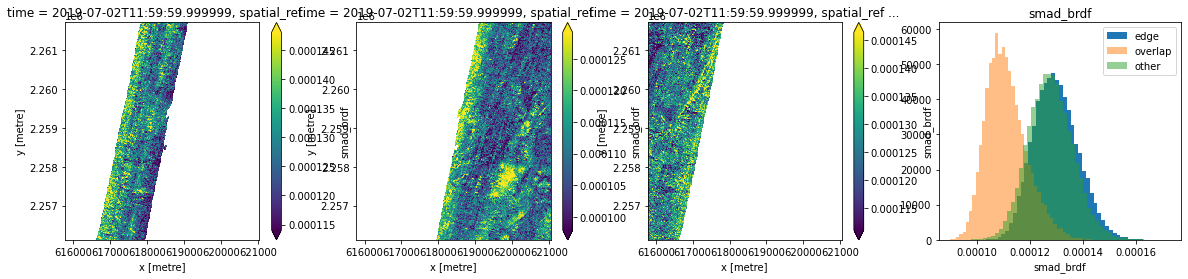

In [131]:
plot_sections(s2_stats,'emad_brdf')
plot_sections(s2_stats,'smad_brdf')

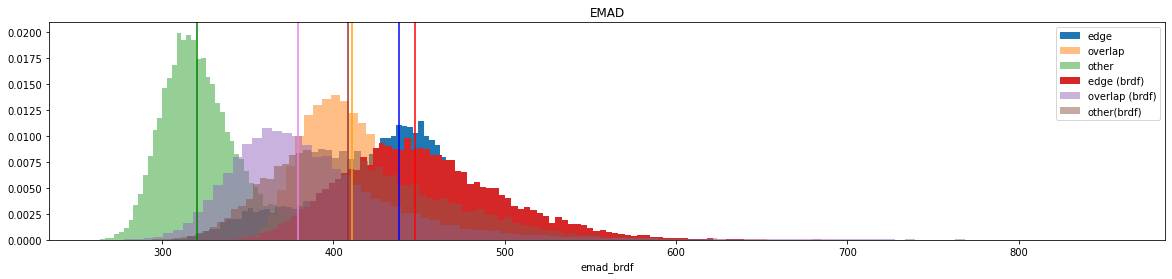

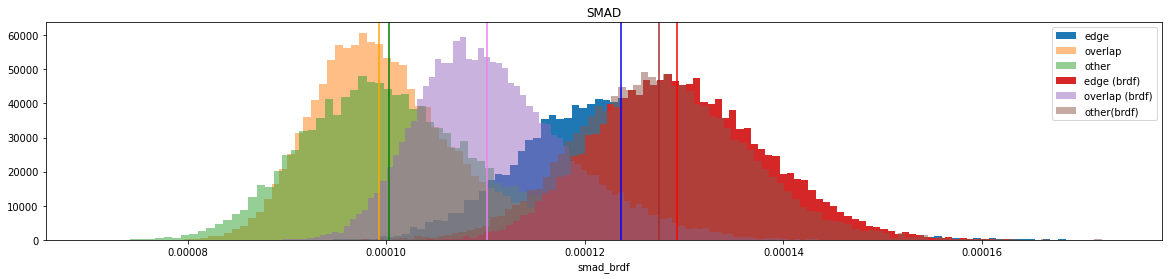

In [133]:
def plot_sections_hist2(ds, band, band2):
    fig, axes = plt.subplots(1,1, figsize=(20,4))
    ds[band].where(edge).plot.hist(bins=100, ax = axes, density=True, label='edge');
    axes.axvline(ds[band].where(edge).median().values, color='blue')
    ds[band].where(overlap).plot.hist(bins=100, ax = axes, density=True, label='overlap', alpha=0.5);
    axes.axvline(ds[band].where(overlap).median().values, color='orange')
    ds[band].where(other).plot.hist(bins=100, ax = axes, density=True, label='other', alpha=0.5);
    axes.axvline(ds[band].where(other).median().values, color='green')

    ds[band2].where(edge).plot.hist(bins=100, ax = axes, density=True, label='edge (brdf)');
    axes.axvline(ds[band2].where(edge).median().values, color='red')
    ds[band2].where(overlap).plot.hist(bins=100, ax = axes, density=True, label='overlap (brdf)', alpha=0.5);
    axes.axvline(ds[band2].where(overlap).median().values, color='violet')
    ds[band2].where(other).plot.hist(bins=100, ax = axes, density=True, label='other(brdf)', alpha=0.5);
    axes.axvline(ds[band2].where(other).median().values, color='brown')
    axes.legend();
    axes.set_title(band)

plot_sections_hist2(s2_stats, 'EMAD', 'emad_brdf')
plot_sections_hist2(s2_stats, 'SMAD', 'smad_brdf')


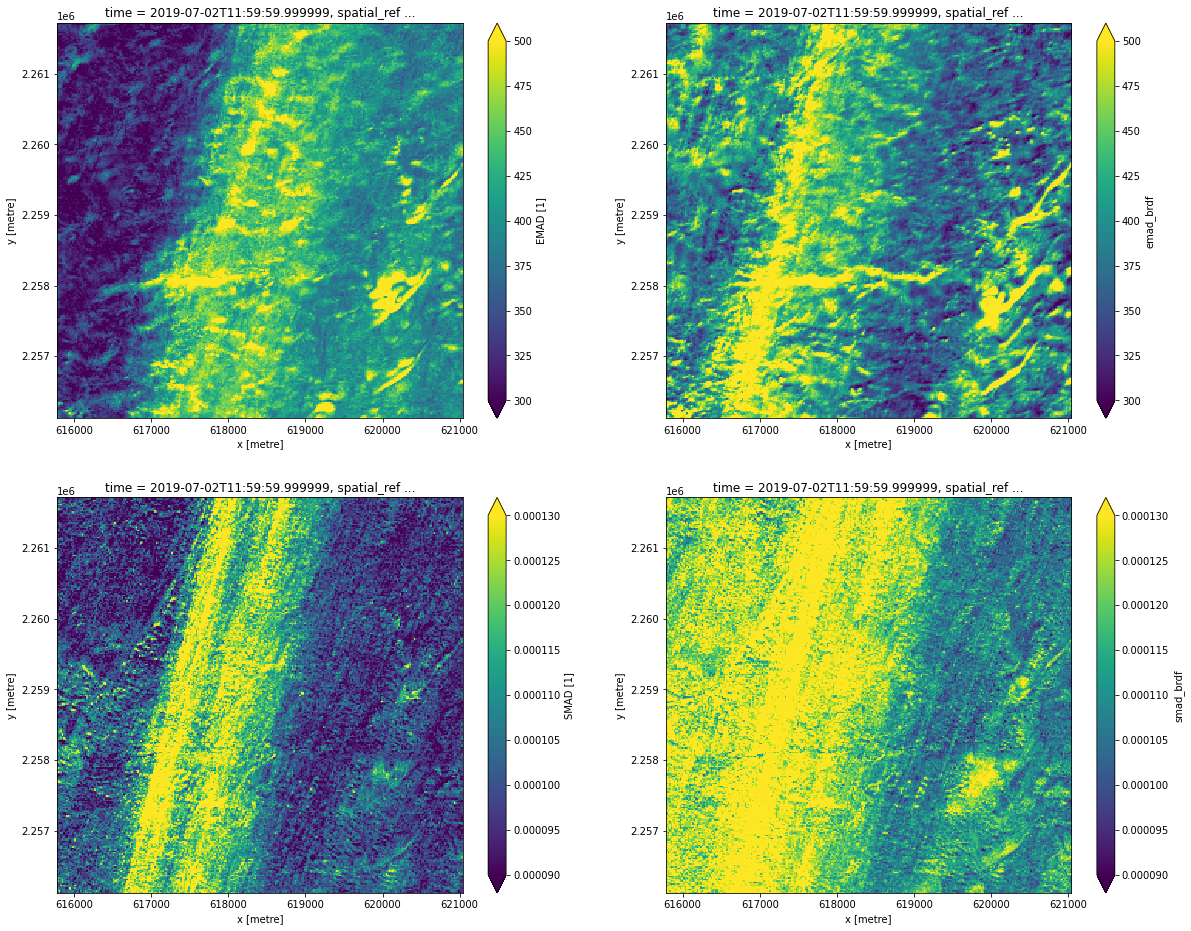

In [152]:
fig, axes = plt.subplots(2 ,2, figsize=(20,16))

s2_stats.EMAD.plot.imshow(vmin=300, vmax=500, ax=axes[0, 0]);
s2_stats.emad_brdf.plot.imshow(vmin=300, vmax=500, ax=axes[0, 1]);
s2_stats.SMAD.plot.imshow(vmin=0.00009, vmax=0.00013, ax=axes[1, 0]);
s2_stats.smad_brdf.plot.imshow(vmin=0.00009, vmax=0.00013, ax=axes[1, 1]);


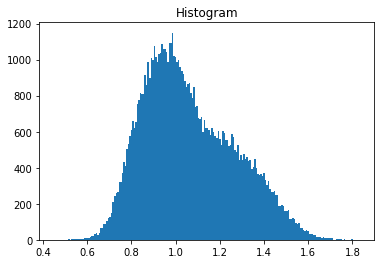

In [120]:
(s2_stats.emad_brdf/s2_stats.EMAD).plot.hist(bins=200);

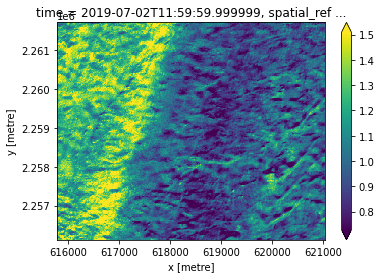

In [122]:
(s2_stats.emad_brdf/s2_stats.EMAD).plot.imshow(robust=True);